# Museums in the Pandemic - Text analytics

**Authors**: Andrea Ballatore (KCL)

**Abstract**: TODO

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [1]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
from termcolor import colored
import sys
import spacy
import numpy as np
from numpy import arange
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
#import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from utils import _is_number

print('env ok')

Conda env: mip_v1
/Users/andreaballatore/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/notebooks
env ok


# Museum text analytics


## Model1: Vectorise text from museum websites

### Connect to DB

In [2]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

DB connected


### Setup spacy NLP

In [7]:
# install language model
!python -m spacy download en_core_web_sm
# Note: if this cell does not work, run the same command 
#       without "!" in the Anaconda terminal

     |████████████████████████████████| 12.0 MB 5.2 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=6e736cfbfe09463c336696b4717b7863a88b5d6766fe3bbf830fc9b77c861a42
  Stored in directory: /private/var/folders/84/_52b_kt95ybgx9pwl31_nvqh0000gn/T/pip-ephem-wheel-cache-dcoj7ilh/wheels/ee/4d/f7/563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [5]:
# set up the spacy environment
import spacy
from spacy import displacy
from collections import Counter
spacy.prefer_gpu()
# load language model
import en_core_web_sm
nlp = en_core_web_sm.load()

In [7]:
# Spacy stopwords
#all_stopwords = nlp.Defaults.stop_words

In [8]:
# get text from websites

from analytics.an_websites import get_attribute_for_webpage_url

session_id = '20210420'
test_urls = ['https://www.britishmuseum.org/']
attrib_name = 'all_text' # 'title'

for url in test_urls:
    print(url)
    res = get_attribute_for_webpage_url(url, session_id, attrib_name, db_conn)
    if not res: continue
    print(res)
    blocks = res.split("\n")
    print("LEN", len(blocks))
    print(blocks)

https://www.britishmuseum.org/
Skip to main content Please enable JavaScript in your web browser to get the best experience. We use cookies to make our website work more efficiently, to provide you with more personalised services or advertising to you, and to analyse traffic on our website. For more information on how we use cookies and how to manage cookies, please follow the 'Read more' link, otherwise select 'Accept and close'. Read more about our cookie policy Accept and close the cookie policy Menu Main navigation Visit Toggle Visit submenu Back
to previous menu —
Visit —
Visit —
Family visits —
Group visits —
Audio guide —
Out-of-hours tours —
Tours and talks —
Object trails —
Accessibility —
Food and drink —
Late opening on Fridays —
Museum map Exhibitions and events Collection Toggle Collection submenu Back
to previous menu —
Collection —
Collection —
Collection online —
Galleries —
Blog —
Audio tour highlights —
The British Museum podcast Learn Toggle Learn submenu Back
to pre

### Preprocess text

In [9]:
MOVED

def spacy_extract_tokens(text):
    """ 
    @returns data frame with tokens with POS, lemma, stop words
    """
    tokens_df = pd.DataFrame()
    text_sentences = nlp(text)
    sent_id = 0
    # segment sentences
    for sentence in text_sentences.sents:
        sent_id += 1
        # for each sentence
        snt_text = sentence.text
        pos_df = pd.DataFrame()
        print(colored('>', 'red'), snt_text)
        for token in sentence:
            # for each token
            tokens_df = tokens_df.append(pd.DataFrame(
                {"sentence_id": sent_id, "token":token.text, 'lemma':token.lemma_,
                 "pos_tag":token.pos_, 'is_stop': token.is_stop}, 
                index=[0]), ignore_index=True)
    return tokens_df

test_texts = ["""We need your support Your support is vital and helps the Museum to share the collection with the world. Make a donation What's online... The flowers of Mary Delany 233 years after her death, Delany's detailed floral collages still delight and inspire. Take a closer look at her work in the collection. How to explore the British Museum from home Whether it's a behind-the-scenes podcast or a closer look at our galleries, here are 10 ways to explore the Museum while we're closed. British histories beyond 'Bridgerton' Inspired by the hit Netflix show, watch a panel discussion exploring the reality behind the fantasy of 'Bridgerton'. Discover the Maya World Take a trip to Mexico and explore a wealth of content from the Maya Research Project, including stories, videos and 3D explorations."""]

for tt in test_texts:
    print(tt)
    print("")
    df = spacy_extract_tokens(tt)
    print("Tokens N =",len(df))
    fout = out_folder+'tmp/museum_text_tokens.csv'
    df.to_csv(fout, index=False)
    print("See tokens in",fout)


We need your support Your support is vital and helps the Museum to share the collection with the world. Make a donation What's online... The flowers of Mary Delany 233 years after her death, Delany's detailed floral collages still delight and inspire. Take a closer look at her work in the collection. How to explore the British Museum from home Whether it's a behind-the-scenes podcast or a closer look at our galleries, here are 10 ways to explore the Museum while we're closed. British histories beyond 'Bridgerton' Inspired by the hit Netflix show, watch a panel discussion exploring the reality behind the fantasy of 'Bridgerton'. Discover the Maya World Take a trip to Mexico and explore a wealth of content from the Maya Research Project, including stories, videos and 3D explorations.

> We need your support Your support is vital and helps the Museum to share the collection with the world.
> Make a donation
> What's online...
> The flowers of Mary Delany 233 years after her death, Delany'

### Annotations

In [3]:
# extract tokens from annotations
from analytics.text_models import get_indicator_annotations

indic_df, ann_df = get_indicator_annotations("../../")
ann_df

,text_phrases,indicator_code,indicator_attributes,notes,example_id
0,Closed now,closed_cur,NaN,NaN,0
1,closed to members of the public until further ...,closed_cur,NaN,NaN,1
2,closed until further notice,closed_cur,NaN,NaN,2
3,closed until Spring 2021,closed_cur,NaN,NaN,3
4,Closed: Until further notice,closed_cur,NaN,NaN,4
...,...,...,...,...,...
146,Bailiffgate is now closed due to Covid.,closed_cur,NaN,NaN,146
147,Visit our online shop,open_onlineshop,NaN,NaN,147
148,The new stunning Felton Group online exhibitio...,online_exhib,_description,NaN,148
149,Stay up to date with what's happening at Baili...,online_engag,NaN,NaN,149


In [4]:
ann_tokens_df = pd.DataFrame()

for index, row in ann_df.iterrows():
    txt = str(row['text_phrases']).strip()
    df = spacy_extract_tokens(txt)
    #print(df)
    df['example_id'] = row['example_id']
    df['indicator_code'] = row['indicator_code']
    ann_tokens_df = pd.concat([ann_tokens_df, df])

# output annotations tokens
fout = out_folder+'tmp/test_annotations_tokens.csv'
ann_tokens_df.to_csv(fout, index=False)
print(fout)

NameError: name 'spacy_extract_tokens' is not defined

### Indicator matching

This code identifies indicators in raw text

In [6]:
ftext = out_folder+'tmp/museum_text_tokens.csv'
text_df = pd.read_csv(ftext)
print(len(text_df))
text_df.sample(10)

findic = out_folder+'tmp/test_annotations_tokens.csv'
ann_df = pd.read_csv(findic)
print(len(ann_df))

ann_df

155
1857


,sentence_id,token,lemma,pos_tag,is_stop,example_id,indicator_code
0,1,Closed,close,VERB,False,0,closed_cur
1,1,now,now,ADV,True,0,closed_cur
2,1,closed,close,VERB,False,1,closed_cur
3,1,to,to,ADP,True,1,closed_cur
4,1,members,member,NOUN,False,1,closed_cur
...,...,...,...,...,...,...,...
1852,1,'ve,have,AUX,True,150,made_covid_safe
1853,1,made,make,VERB,True,150,made_covid_safe
1854,1,your,-PRON-,DET,True,150,made_covid_safe
1855,1,visit,visit,NOUN,False,150,made_covid_safe


Options for matches
- Case sensitive/insens (lower case) 
- match lemma
- match token
- stopwords or not

In [9]:
print(text_df.columns)
print(ann_df.columns)

Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop'], dtype='object')
Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop', 'example_id',
       'indicator_code'],
      dtype='object')


In [41]:
MOVED

def _filter_tokens(df, keep_stopwords=True):
    """ Remove tokens that do not carry semantic content """
    
    if not keep_stopwords:
        df = df[~df['is_stop']]
    
    filt_df = df[~df['pos_tag'].isin(['DET','ADP','PRON','PUNCT'])]
    return filt_df


def _match_tokens(musetxt_df, annot_df, case_sensitive, keep_stopwords):
    """
    TODO
    """
    assert len(musetxt_df)>=0
    assert len(annot_df)>=0
    # set up options
    prefix = 'var_'
    suffix = ''
    if case_sensitive: suffix = '_csens'
    else: suffix = '_cinsens'
    if case_sensitive: suffix = '_csens'
    else: suffix = '_cinsens'
        
    if keep_stopwords: suffix += '_wstopw'
    else: suffix += '_nostopw'
        
    # filter tokens
    filt_text_df = _filter_tokens(musetxt_df, keep_stopwords)
    filt_ann_df = _filter_tokens(annot_df, keep_stopwords)
    
    # case in/sensitive
    if not case_sensitive:
        # make lower case
        filt_text_df.loc[:, 'lemma'] = filt_text_df.loc[:, 'lemma'].str.lower()
        filt_text_df.loc[:, 'token'] = filt_text_df.loc[:, 'token'].str.lower()
        filt_ann_df.loc[:, 'lemma'] = filt_ann_df.loc[:, 'lemma'].str.lower()
        filt_ann_df.loc[:, 'token'] = filt_ann_df.loc[:, 'token'].str.lower()
        
    # generate match variables for each example/text pair
    lemmas_df = filt_text_df.merge(filt_ann_df, on=['lemma'])
    tokens_df = filt_text_df.merge(filt_ann_df, on=['token'])
    lemmas_m = " ".join(lemmas_df['lemma'].tolist())
    tokens_m = " ".join(tokens_df['token'].tolist())
    vars_d = {
        prefix+'lemmas_n'+suffix:len(lemmas_df), 
        prefix+'lemmas_m'+suffix: lemmas_m, 
        prefix+'tokens_n'+suffix:len(tokens_df),
        prefix+'tokens_m'+suffix: tokens_m
    }
    return vars_d


def match_musetext_indicators(muse_id, txt_df, annot_df):
    """ Main match loop between set of sentences and set of annotations """
    assert muse_id
    assert len(txt_df) >= 0
    assert len(annot_df) >= 0
    
    df = pd.DataFrame()
    
    for sentence_name, txt_sent_df in txt_df.groupby('sentence_id'):
        #print(txt_sent_df)
        for ann_name, ann_example_df in annot_df.groupby('example_id'):
            #print(ann_example_df)
            tmpdf = _match_musetext_vs_indicator_example(muse_id, txt_sent_df, ann_example_df)
            df = df.append(tmpdf)
    
    df.reset_index()
    return df

    
def _match_musetext_vs_indicator_example(muse_id, txt_df, annot_df):
    """ 
    Match single text sentence with single annotation example
    """
    #print("_match_musetext_vs_indicator_example")
    # get txt sentence id
    sentence_id = txt_df['sentence_id'].tolist()[0]
    # get annotation example id and code
    example_id = annot_df['example_id'].tolist()[0]
    indicator_code = annot_df['indicator_code'].tolist()[0]
    
    d = {}
    for cs in [True, False]:
        for sw in [True, False]:
            #print('debug 2')
            match_vars_d = _match_tokens(txt_df, annot_df, cs, sw)
            d.update(match_vars_d)
    
    # sum all values
    all_nums = [x for x in d.values() if _is_number(x)]
    d['all_sum_n'] = sum(all_nums)
    
    # base dictionary
    res_d = {'muse_id':muse_id, 
             'muse_text_sentence_id': [sentence_id], 
             'annotation_example_id':[example_id],
             'muse_text_sentence_len': len(txt_df), 
             'annotation_example_len': len(annot_df)}
    res_d.update(d)
    
    res_df = pd.DataFrame(data=res_d)
    assert len(res_df)>0
    return res_df

In [42]:
# call test match 
muse_id = 'test.123'
df = match_musetext_indicators(muse_id, text_df, ann_df)

print(len(df))
fout = out_folder + 'tmp/all_matches_test.csv'
df.to_csv(fout, index=False)

1510


In [71]:
OLD
# iterate over each group
#for group_name, df_group in df1_grouped:
    
    # match lemmas
    matched_df = filt_text_df.merge(filt_ann_df, on=target_col, suffixes=('_txt', '_ann'))
    print(matched_df.columns)
    matched_df.to_csv(out_folder+'tmp/indic_match_counts_all.csv', index=False)

    df = matched_df.groupby(['sentence_id_txt','example_id','indicator_code']).size().reset_index(name='n_match_'+target_col)
    print(df)
    df.to_csv(out_folder+'tmp/indic_match_counts_counts.csv', index=False)
    #return df
    
mdf = match_tokens(text_df, ann_df, 'lemma')
tdf = match_tokens(text_df, ann_df, 'token')
all_matches_df = mdf.merge(tdf, on=['sentence_id_txt','example_id','indicator_code'], how='outer')

all_matches_df['n_match_lemma'] = all_matches_df['n_match_lemma'].fillna(0)
all_matches_df['n_match_token'] = all_matches_df['n_match_token'].fillna(0)
all_matches_df

Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop'], dtype='object')
Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop', 'example_id',
       'indicator_code'],
      dtype='object')


NameError: name 'df1_grouped' is not defined

# Text analysis from DB

Analyse text stats from DB

In [26]:
mus_df = get_museums_sample_urls(out_folder)

museums urls: ../../data/museums/correct_url_stratified_sample_401.tsv
get_museums_w_web_urls Museums=400 URLs=400


## Download matches from DB

In [3]:
assert db_conn

t = "analytics.text_indic_ann_matches"
sql = """select count(distinct muse_id) from {} t;""".format(t)
print(sql)
df = pd.read_sql(sql, db_conn)
df

select count(distinct muse_id) from analytics.text_indic_ann_matches t;


,count
0,357


In [4]:
# get sample of matches museums
sample_df = mus_df.sample(10)
muse_ids = sample_df.muse_id.tolist()
muse_ids = str(muse_ids).replace('[','(').replace(']',')')
#print(muse_ids)
sql = """select * from {} t where muse_id in {};""".format(t, muse_ids)
print(sql)
df = pd.read_sql(sql, db_conn)

fn = out_folder + 'tmp/match_samples.tsv'
print(df.keep_stopwords.describe())
df.to_csv(fn, sep='\t', index=False)
df.describe().transpose()
df.columns

NameError: name 'mus_df' is not defined

In [60]:
# get all matches from DB (SLOW)
sql = """select muse_id, example_id, sentence_id, indicator_code, token_n, lemma_n, 
                ann_overlap_lemma, ann_overlap_token, example_len, ann_ex_tokens, page_tokens,
                txt_overlap_lemma, txt_overlap_token, ann_overlap_criticwords
    from analytics.text_indic_ann_matches t where keep_stopwords;"""
df = pd.read_sql(sql, db_conn)
print(len(df))

# write df to file
matches_fn = out_folder+'tmp/matches_dump_df.pik'
df.to_pickle(matches_fn)

884399


## Load matches from pik

In [139]:
matches_fn = out_folder+'tmp/matches_dump_df.pik'
#matches_fn = out_folder+'tmp/matches_dump_df_v1.pik'

df = pd.read_pickle(matches_fn)

# generate derived fields
df["lemmatoken_n"] = df[["lemma_n", "token_n"]].max(axis=1)
df["lemmatoken_n"].describe()

df["ann_overlap_tokenlemma"] = df["lemmatoken_n"]/df['example_len']

assert df.ann_overlap_tokenlemma.between(0,1).all(),'incorrect range'

df.sample(10)

,muse_id,example_id,sentence_id,indicator_code,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,ann_ex_tokens,page_tokens,txt_overlap_lemma,txt_overlap_token,ann_overlap_criticwords,lemmatoken_n,ann_overlap_tokenlemma
764227,mm.MDN.036,ann_ex_00100,mus_page1015966_sent00003,funding_fundraise,1.0,1.0,0.25000,0.25000,4,every donation important us,castletown day centre an authentic recreation ...,0.03448,0.03448,0.0,1.0,0.250000
739217,mm.musa.092,ann_ex_00162,mus_page601175_sent00003,lang_difficulty,1.0,1.0,0.09091,0.09091,11,current situation drastically reduced our main...,our cause days,0.33333,0.33333,0.0,1.0,0.090909
779413,mm.mald.124,ann_ex_00218,mus_page57721_sent00065,reopen_intent,0.0,1.0,0.20000,0.00000,5,look forward welcoming you back,we encourage everybody to follow latest guidel...,0.08333,0.00000,0.0,1.0,0.200000
219770,mm.domus.NE016,ann_ex_00231,mus_page505351_sent00126,reopen_intent,1.0,1.0,0.14286,0.14286,7,welcome visitors back our site soon able,your clues when you enter site then exploring,0.12500,0.12500,0.0,1.0,0.142857
340427,mm.domus.NW070,ann_ex_00090,mus_page15046_sent00056,funding_fundraise,1.0,2.0,0.66667,0.33333,3,support our future,every purchase you make supports museum our vi...,0.22222,0.11111,0.0,2.0,0.666667
345591,mm.domus.NW053,ann_ex_00111,mus_page711921_sent00070,funding_fundraise,1.0,1.0,0.50000,0.50000,2,support us,find us find us south grasmere village a591 ke...,0.09091,0.09091,0.5,1.0,0.500000
837768,mm.domus.WM115,ann_ex_00157,mus_page419620_sent00095,lang_difficulty,0.0,1.0,0.10000,0.00000,10,it unclear moment just how much will cover dif...,please note we ca n't allow pushchairs buildin...,0.06667,0.00000,0.0,1.0,0.100000
715382,mm.domus.SW137,ann_ex_00008,mus_page759472_sent00020,closed_cur,1.0,1.0,0.50000,0.50000,2,museum closed,tiverton museum mid devon life treasure trove ...,0.05556,0.05556,0.5,1.0,0.500000
313179,mm.wiki.263,ann_ex_00155,mus_page771931_sent00001,lang_difficulty,1.0,1.0,0.25000,0.25000,4,serious financial impact museum,skip to content north ings farm museum menu ho...,0.04762,0.04762,0.0,1.0,0.250000
448926,mm.domus.SC176,ann_ex_00144,mus_page773627_sent00012,lang_difficulty,1.0,0.0,0.00000,0.33333,3,difficult challenging year,what news contact paxton house registered char...,0.00000,0.06667,1.0,1.0,0.333333


## Descriptive stats

### Match distributions

In [5]:
# descriptive stats of all values
#df.groupby('keep_stopwords').describe().transpose()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
token_n,883265.0,1.030551,0.497137,0.000000,1.00000,1.000000,1.00,8.0
lemma_n,883265.0,1.124612,0.441228,0.000000,1.00000,1.000000,1.00,8.0
ann_overlap_lemma,883265.0,0.203200,0.124995,0.000000,0.12500,0.166670,0.25,1.0
ann_overlap_token,883265.0,0.186740,0.131619,0.000000,0.11111,0.166670,0.25,1.0
example_len,883265.0,6.751379,3.198704,1.000000,4.00000,6.000000,8.00,17.0
lemmatoken_n,883265.0,1.146149,0.420205,1.000000,1.00000,1.000000,1.00,8.0
ann_overlap_tokenlemma,883265.0,0.209669,0.127575,0.058824,0.12500,0.166667,0.25,1.0


### Indicator stats

In [7]:
# describe indicators
indic_df = round(df['indicator_code'].value_counts(normalize=True)*100,1)
indic_df.columns = ['n_matches']
indic_df.to_csv(out_folder + 'tmp/indicator_stats.csv')
print('N matches =',len(df))
indic_df

N matches = 884399


funding_fundraise      19.0
reopen_intent          13.8
closed_cur             12.7
lang_difficulty        12.5
staff_working           6.2
open_onlineshop         4.8
funding_gov_emer        3.7
online_engag            3.7
staff_hiring            3.2
finance_health          2.7
funding_other_emer      2.6
reopen_plan             2.5
funding_did_not_get     2.3
closed_perm             2.1
online_event            1.8
open_cur                1.5
closed_indef            1.4
online_exhib            1.2
project_postpone        1.1
made_covid_safe         0.6
open_cafe               0.4
open_garden             0.3
staff_restruct          0.1
Name: indicator_code, dtype: float64

                 count      mean       std  min  25%  50%  75%  max
token_n       883265.0  1.030551  0.497137  0.0  1.0  1.0  1.0  8.0
lemma_n       883265.0  1.124612  0.441228  0.0  1.0  1.0  1.0  8.0
lemmatoken_n  883265.0  1.146149  0.420205  1.0  1.0  1.0  1.0  8.0


array([[<AxesSubplot:title={'center':'token_n'}>,
        <AxesSubplot:title={'center':'lemma_n'}>],
       [<AxesSubplot:title={'center':'lemmatoken_n'}>, <AxesSubplot:>]],
      dtype=object)

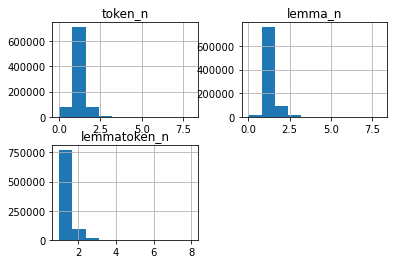

In [7]:
# distribution token_n and lemma_n
print(df[['token_n','lemma_n','lemmatoken_n']].describe().transpose())
df[['token_n','lemma_n','lemmatoken_n']].hist(bins=10)

array([[<AxesSubplot:title={'center':'lemmatoken_n'}>]], dtype=object)

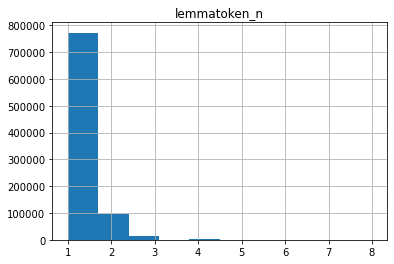

In [245]:
df[['lemmatoken_n']].hist(bins=10)

             lemma_n
count  107526.000000
mean        2.167718
std         0.468068
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         8.000000


array([[<AxesSubplot:title={'center':'lemma_n'}>]], dtype=object)

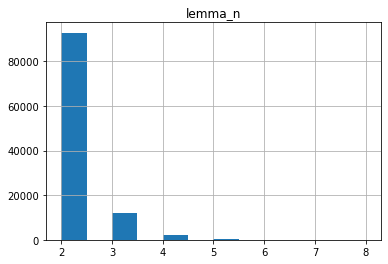

In [32]:
# exclude one match
print(df[['lemma_n']][df.lemma_n > 1].describe())
df[['lemma_n']][df.lemma_n > 1].hist(bins=12)

### Overlaps distributions

                           count      mean       std       min      25%  \
ann_overlap_token       884399.0  0.187069  0.132090  0.000000  0.11111   
ann_overlap_lemma       884399.0  0.202859  0.125486  0.000000  0.12500   
ann_overlap_tokenlemma  884399.0  0.209418  0.128142  0.058824  0.12500   

                             50%   75%  max  
ann_overlap_token       0.166670  0.25  1.0  
ann_overlap_lemma       0.166670  0.25  1.0  
ann_overlap_tokenlemma  0.166667  0.25  1.0  


array([[<AxesSubplot:title={'center':'ann_overlap_tokenlemma'}>]],
      dtype=object)

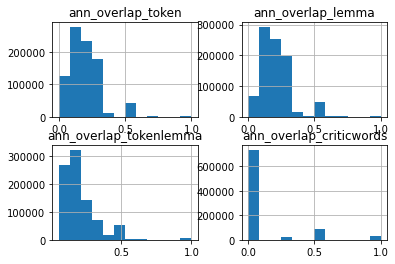

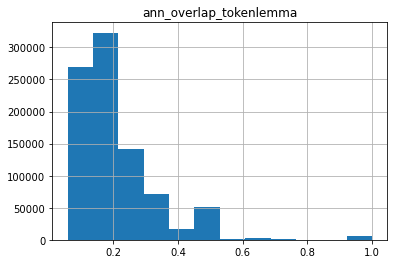

In [8]:
print(df[['ann_overlap_token','ann_overlap_lemma','ann_overlap_tokenlemma']].describe().transpose())
df[['ann_overlap_token','ann_overlap_lemma','ann_overlap_tokenlemma','ann_overlap_criticwords']].hist(bins=12)

df[['ann_overlap_tokenlemma']].hist(bins=12)

count    884399.000000
mean          6.769431
std           3.191218
min           1.000000
25%           5.000000
50%           6.000000
75%           8.000000
max          17.000000
Name: example_len, dtype: float64
matches with annotations > 1: 881913


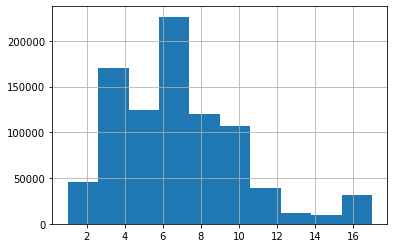

In [9]:
# show length of annotations
print(df['example_len'].describe())
df['example_len'].hist(bins=10)

# filter annotations that are too short: valid df
df = df[df['example_len']>1]
print('matches with annotations > 1:', len(df))

In [10]:
# count number of examples
indic_df = df[['indicator_code','example_id']].groupby(['indicator_code']).describe()
indic_df = indic_df.sort_values(('example_id', 'unique'), ascending=False)
indic_df

example_id                            
                         count unique           top   freq
indicator_code                                            
funding_fundraise       168235     52  ann_ex_00101   6981
reopen_intent           120567     41  ann_ex_00251   5979
lang_difficulty         110359     38  ann_ex_00159   7626
closed_cur              110859     37  ann_ex_00029   7942
online_engag             32445     12  ann_ex_00172   6967
open_onlineshop          42028     11  ann_ex_00200   6593
staff_working            55064     11  ann_ex_00270   6886
funding_gov_emer         33123     11  ann_ex_00118   6022
staff_hiring             28282      8  ann_ex_00263   6396
online_event             15500      8  ann_ex_00185   3871
funding_did_not_get      20342      7  ann_ex_00054   6001
online_exhib             10211      7  ann_ex_00191   4406
finance_health           23678      6  ann_ex_00053   6519
closed_indef             12220      5  ann_ex_00041   3908
closed_perm              18703      5  ann_ex_00045   5792
funding_other_emer       23012      4  ann_ex_00127  10540
reopen_plan              21967      4  ann_ex_00256   6252
open_cur                 13590      3  ann_ex_00197   9380
project_postpone          9921      3  ann_ex_00210   6015
made_covid_safe           5184      1  ann_ex_00166   5184
open_cafe                 3577      1  ann_ex_00194   3577
open_garden               2561      1  ann_ex_00198   2561
staff_restruct             485      1  ann_ex_00266    485

## Evaluation of matching method

### Make match sample stratified on overlap bins

Choose sample for manual annotation of matches

In [11]:
df['ann_overlap_tokenlemma']
cut_bins = [0, .25, .5, .6, .7, .8, .9, 1.01]
df['overlap_bin'] = pd.cut(df['ann_overlap_tokenlemma'], bins=cut_bins)
df['overlap_bin'].value_counts()

(0.0, 0.25]    721819
(0.25, 0.5]    151282
(0.6, 0.7]       3124
(0.9, 1.01]      2809
(0.5, 0.6]       1530
(0.7, 0.8]       1189
(0.8, 0.9]        160
Name: overlap_bin, dtype: int64

In [10]:
# less than 0.2% of cases have annotation length == 1
#(len(df[df.example_len == 1])/len(df))*100

#df = df[df.example_len > 1]
df.example_len.describe()

count    883265.000000
mean          6.751379
std           3.198704
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          17.000000
Name: example_len, dtype: float64

In [11]:
sample_df = pd.DataFrame()
sample_n = 100
for bin_name, subdf in df.groupby('overlap_bin'):
    smpl = subdf.sample(sample_n, random_state=1359)
    sample_df = sample_df.append(smpl)
    
sample_df['overlap_bin'].value_counts()

sample_df['valid_match'] = ''

# shuffle sample
sample_df = sample_df.sample(frac=1.0)

# generate sample
sample_df.to_csv(out_folder+'tmp/match_sample_for_validation.tsv', index=False, sep='\t')
sample_df.to_excel(out_folder+'tmp/match_sample_for_validation.xlsx', index=False)

sample_df

,muse_id,example_id,sentence_id,indicator_code,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,ann_ex_tokens,page_tokens,lemmatoken_n,ann_overlap_tokenlemma,overlap_bin,valid_match
873099,mm.aim.0112,ann_ex_00251,mus_page599129_sent00016,reopen_intent,5.0,5.0,0.83333,0.83333,6,look forward welcoming you again soon,we look forward seeing you again soon,5.0,0.833333,"(0.8, 0.9]",
356289,mm.nimc.009,ann_ex_00272,mus_page591031_sent00055,staff_working,1.0,1.0,0.16667,0.16667,6,team continues to work winter months,booking information contact holidays team sign...,1.0,0.166667,"(0.0, 0.25]",
390682,mm.domus.SC289,ann_ex_00025,mus_page520643_sent00055,closed_cur,3.0,3.0,0.75000,0.75000,4,currently closed government advice,library currently closed government restrictions,3.0,0.750000,"(0.7, 0.8]",
722505,mm.aim.1022,ann_ex_00145,mus_page439904_sent00018,lang_difficulty,2.0,2.0,0.28571,0.28571,7,we to make some changes order survive,seed potatoes onion sets compost plants may st...,2.0,0.285714,"(0.25, 0.5]",
632814,mm.domus.SW238,ann_ex_00030,mus_page121939_sent00033,closed_cur,4.0,4.0,0.80000,0.80000,5,currently closed line government restrictions,line government guidance house currently closed,4.0,0.800000,"(0.7, 0.8]",
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222113,mm.New.103,ann_ex_00248,mus_page601250_sent00037,reopen_intent,5.0,5.0,0.83333,0.83333,6,look forward welcoming you again soon,we look forward welcoming you back safely soon...,5.0,0.833333,"(0.8, 0.9]",
443107,mm.New.66,ann_ex_00256,mus_page420402_sent00025,reopen_intent,5.0,5.0,0.62500,0.62500,8,we intend to open again fully very soon,we will open again soon it safe to so so pleas...,5.0,0.625000,"(0.6, 0.7]",
349031,mm.domus.NI024,ann_ex_00132,mus_page247795_sent00090,lang_difficulty,1.0,2.0,0.66667,0.33333,3,to cover shortfall,line government guidance you required to wear ...,2.0,0.666667,"(0.6, 0.7]",
86443,mm.misc.015,ann_ex_00251,mus_page563788_sent00014,reopen_intent,5.0,5.0,0.83333,0.83333,6,look forward welcoming you again soon,our doors currently closed we look forward wel...,5.0,0.833333,"(0.8, 0.9]",


### Generate matching eval dataset

- Manually annotated by AB, AP, PW.
- Two independent annotators for each match.
- Disagreement on 11.5% of cases, manually resolved in discussion with a third independent annotator.

- in ann_ex_tokens, when the word "support" appears it implicitly intends to mean "financial support" whereas in the page_tokens "support" could be mean other types of support as well. Anyway, I marked these as "T" matches. 
- in ann_ex_tokens, phrases such as "currently closed" are implicitly intended to apply to the museum as a whole; whereas the page_tokens seem sometimes to be referreing to closures of parts of the museum, e.g. the grounds, the tea room etc.  I have generally marked these too as "T" matches. 
- in ann_ex_tokens, the indicator "funding_fundraise" was I think intended to mean a special fund-raising programme relating to difficulties brought about due to covid. Whereas sometimes ann_ex_tokens and/or page_tokens contains the word "donate" which could be referring to just the museum's standard donations programme.  
- some of the ann_ex_tokens look a bit "dodgy" to me. The original phrase may have made sense, but by the time the stop words are removed there are sometimes tokens present that seem extraneous/irrelevant.  
- it seems that for some of the ann_ex_tokens, we need all of the tokens to be present in the page_tokens list in order to deem that this is a true match; whereas for others the level of coverage can be a bit lower. Is this is something that can be factored into the model training? 

#### Eval data v1

In [138]:
valid_ann_df = pd.read_excel(out_folder+'data/annotations/match_sample_for_validation-v5.xlsx')
print(len(valid_ann_df))
print(valid_ann_df.columns)

# generate dummy vars
indicator_dummy_df = pd.get_dummies(valid_ann_df[['indicator_code']], drop_first=True)
indicator_dummy_vars = indicator_dummy_df.columns
print(valid_ann_df.shape)
valid_ann_df = pd.concat([valid_ann_df, indicator_dummy_df], axis=1)
print(valid_ann_df.shape)
print(indicator_dummy_vars)
valid_ann_df['valid_match_b'] = valid_ann_df['valid_match'].map({'T': True, 'F': False})
valid_ann_df['valid_match_b2'] = valid_ann_df['valid_match_2'].map({'T': True, 'F': False})
valid_ann_df.sample(10)

# add extra vars from matches
idx_cols = ['muse_id', 'example_id', 'sentence_id', 'indicator_code']
cols = idx_cols + ['txt_overlap_lemma','txt_overlap_token']
n = len(valid_ann_df)
valid_ann_df = valid_ann_df.merge(df[cols], on=idx_cols)
assert len(valid_ann_df) == n,len(valid_ann_df)

# derived fields
valid_ann_df["txt_overlap_tokenlemma"] = valid_ann_df[["txt_overlap_lemma", "txt_overlap_token"]].max(axis=1)

assert valid_ann_df.txt_overlap_tokenlemma.between(0,1).all(),'incorrect range'

valid_ann_df.to_pickle(out_folder+'tmp/matches_valid_ann_df_v1.pik')

700
Index(['muse_id', 'example_id', 'sentence_id', 'indicator_code', 'token_n',
       'lemma_n', 'ann_overlap_lemma', 'ann_overlap_token', 'example_len',
       'ann_ex_tokens', 'page_tokens', 'lemmatoken_n',
       'ann_overlap_tokenlemma', 'overlap_bin', 'valid_match', 'annotator',
       'valid_match_2', 'Unnamed: 17'],
      dtype='object')
(700, 18)
(700, 37)
Index(['indicator_code_closed_indef', 'indicator_code_closed_perm',
       'indicator_code_finance_health', 'indicator_code_funding_did_not_get',
       'indicator_code_funding_fundraise', 'indicator_code_funding_gov_emer',
       'indicator_code_funding_other_emer', 'indicator_code_lang_difficulty',
       'indicator_code_online_engag', 'indicator_code_online_event',
       'indicator_code_online_exhib', 'indicator_code_open_cafe',
       'indicator_code_open_cur', 'indicator_code_open_onlineshop',
       'indicator_code_project_postpone', 'indicator_code_reopen_intent',
       'indicator_code_reopen_plan', 'indicator_code_

#### Eval data v2

In [141]:
valid_ann_df = pd.read_excel(out_folder+'data/annotations/match_sample_for_validation-v5.xlsx')
orig_valid_ann_df = valid_ann_df
print(len(valid_ann_df))
print(valid_ann_df.columns)
print(len(df))

valid_matches = valid_ann_df[['muse_id','sentence_id','page_tokens','indicator_code','ann_ex_tokens','valid_match']].drop_duplicates()
#print(len(valid_ann_df.drop_duplicates()))
all_matches = df #[['muse_id','sentence_id','example_id','indicator_code','ann_ex_tokens']]
# because IDs example_id mismatch, match rows based on tokens
assert len(all_matches)==884399
print(df.columns)

df2 = valid_matches.merge(all_matches, how='left',
            on=['muse_id','sentence_id','ann_ex_tokens','indicator_code','page_tokens']) 
                    #suffixes=('_left', '_right'))
#df2.sample(10)
#valid_matches
#all_matches
valid_ann_df = df2.drop('example_id',axis=1).drop_duplicates()
n = 700
valid_ann_df = valid_ann_df[~valid_ann_df.lemma_n.isna()].sample(n,random_state=10)

valid_ann_df['valid_match_b'] = valid_ann_df['valid_match'].map({'T': True, 'F': False})

#del all_matches, valid_matches
print(len(valid_ann_df))
valid_ann_df.to_excel(out_folder+'tmp/match_sample_for_validation-v6.xlsx', index=False)
#orig_valid_ann_df.to_excel(out_folder+'tmp/validation_with_critical_orig.xlsx', index=False)
valid_ann_df.to_pickle(out_folder+'tmp/matches_valid_ann_df_v2.pik')

700
Index(['muse_id', 'example_id', 'sentence_id', 'indicator_code', 'token_n',
       'lemma_n', 'ann_overlap_lemma', 'ann_overlap_token', 'example_len',
       'ann_ex_tokens', 'page_tokens', 'lemmatoken_n',
       'ann_overlap_tokenlemma', 'overlap_bin', 'valid_match', 'annotator',
       'valid_match_2', 'Unnamed: 17'],
      dtype='object')
884399
Index(['muse_id', 'example_id', 'sentence_id', 'indicator_code', 'token_n',
       'lemma_n', 'ann_overlap_lemma', 'ann_overlap_token', 'example_len',
       'ann_ex_tokens', 'page_tokens', 'txt_overlap_lemma',
       'txt_overlap_token', 'ann_overlap_criticwords', 'lemmatoken_n',
       'ann_overlap_tokenlemma'],
      dtype='object')
700


In [108]:
# generate dummy vars
indicator_dummy_df = pd.get_dummies(valid_ann_df[['indicator_code']], drop_first=True)
indicator_dummy_vars = indicator_dummy_df.columns
print(valid_ann_df.shape)
valid_ann_df = pd.concat([valid_ann_df, indicator_dummy_df], axis=1)
print(valid_ann_df.shape)
print(indicator_dummy_vars)
#valid_ann_df['valid_match_b'] = valid_ann_df['valid_match'].map({'T': True, 'F': False})
#valid_ann_df['valid_match_b2'] = valid_ann_df['valid_match_2'].map({'T': True, 'F': False})
#valid_ann_df.sample(10)

# add extra vars from matches
#idx_cols = ['muse_id', 'example_id', 'sentence_id', 'indicator_code']
#cols = idx_cols + ['txt_overlap_lemma','txt_overlap_token']
#n = len(valid_ann_df)
#valid_ann_df = valid_ann_df.merge(df[cols], on=idx_cols)
#assert len(valid_ann_df) == n

# derived fields
print(valid_ann_df.txt_overlap_lemma.min())
print(valid_ann_df.txt_overlap_token.min())
valid_ann_df["txt_overlap_tokenlemma"] = valid_ann_df[["txt_overlap_lemma", "txt_overlap_token"]].max(axis=1)

print(valid_ann_df.txt_overlap_tokenlemma.min())

assert valid_ann_df.txt_overlap_tokenlemma.between(0,1).all(),'incorrect range'

valid_ann_df

(700, 17)
(700, 36)
Index(['indicator_code_closed_indef', 'indicator_code_closed_perm',
       'indicator_code_finance_health', 'indicator_code_funding_did_not_get',
       'indicator_code_funding_fundraise', 'indicator_code_funding_gov_emer',
       'indicator_code_funding_other_emer', 'indicator_code_lang_difficulty',
       'indicator_code_online_engag', 'indicator_code_online_event',
       'indicator_code_online_exhib', 'indicator_code_open_cafe',
       'indicator_code_open_cur', 'indicator_code_open_onlineshop',
       'indicator_code_project_postpone', 'indicator_code_reopen_intent',
       'indicator_code_reopen_plan', 'indicator_code_staff_hiring',
       'indicator_code_staff_working'],
      dtype='object')
0.0
0.0
0.01316


,muse_id,sentence_id,page_tokens,indicator_code,ann_ex_tokens,valid_match,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,...,indicator_code_online_exhib,indicator_code_open_cafe,indicator_code_open_cur,indicator_code_open_onlineshop,indicator_code_project_postpone,indicator_code_reopen_intent,indicator_code_reopen_plan,indicator_code_staff_hiring,indicator_code_staff_working,txt_overlap_tokenlemma
664,mm.domus.SC279,mus_page132727_sent00072,things to see support us charity we rely your ...,funding_fundraise,support us,T,2.0,2.0,1.00000,1.00000,...,0,0,0,0,0,0,0,0,0,0.11111
342,mm.wiki.256,mus_page664754_sent00006,we limbo time county council personnel working...,closed_cur,we ’re closed,T,2.0,2.0,0.66667,0.66667,...,0,0,0,0,0,0,0,0,0,0.20000
336,mm.New.103,mus_page720421_sent00047,read more meet our distinguished friends suppo...,funding_fundraise,support our future,T,2.0,2.0,0.66667,0.66667,...,0,0,0,0,0,0,0,0,0,0.25000
92,mm.domus.SE328,mus_page628548_sent00132,to enrich perfect your online experience littl...,funding_fundraise,to help support further,F,1.0,1.0,0.25000,0.25000,...,0,0,0,0,0,0,0,0,0,0.03704
788,mm.New.66,mus_page420402_sent00038,see collection online,online_exhib,online collection,T,2.0,2.0,1.00000,1.00000,...,1,0,0,0,0,0,0,0,0,0.66667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,mm.domus.WM033,mus_page462728_sent00031,cottage anne hathaway cottage currently closed...,closed_cur,currently closed,T,2.0,1.0,0.50000,1.00000,...,0,0,0,0,0,0,0,0,0,0.06897
359,mm.aim.0304,mus_page53237_sent00035,comments closed museum will remain closed year...,online_engag,we still telling incredible stories online,T,4.0,4.0,0.66667,0.66667,...,0,0,0,0,0,0,0,0,0,0.15385
480,mm.domus.SC279,mus_page132727_sent00051,we ca n't wait to welcome you back national wa...,reopen_intent,welcoming you back soon,T,2.0,3.0,0.75000,0.50000,...,0,0,0,0,0,1,0,0,0,0.27273
523,mm.domus.SE425,mus_page229330_sent00016,please support us difficult time,funding_fundraise,please support us time donation,T,4.0,4.0,0.80000,0.80000,...,0,0,0,0,0,0,0,0,0,0.80000


In [103]:
valid_ann_df.valid_match.describe()
print(valid_ann_df.valid_match_b.value_counts())
print(valid_ann_df.valid_match_b2.value_counts())

# compare different annotators
print("Mismatches")
valid_ann_df['valid_equal'] = valid_ann_df.valid_match_b == valid_ann_df.valid_match_b2
valid_ann_df['valid_equal'].value_counts()

AttributeError: 'DataFrame' object has no attribute 'valid_match_b'

### Simple threshold method

In [109]:
len(valid_ann_df)
print(valid_ann_df.ann_overlap_tokenlemma.describe())

count    700.000000
mean       0.635363
std        0.266339
min        0.058824
25%        0.500000
50%        0.666667
75%        0.833333
max        1.000000
Name: ann_overlap_tokenlemma, dtype: float64


In [110]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# test 
precision_recall_fscore_support([True, False, True, False], [True, False, True, True], average='binary')

(0.6666666666666666, 1.0, 0.8, None)

In [125]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

thdf = valid_ann_df.copy()

resdf = pd.DataFrame()

# loop through thresholds
for th in arange(.2,1.001,.05):
    print("---\nKeeping values ann_overlap_tokenlemma above: ",th)
    # PICK A VARIABLE
    thdf['predicted'] = thdf.ann_overlap_tokenlemma >= th
    #thdf['predicted'] = thdf.ann_overlap_criticwords >= th
    
    precision, recall, fscore, support = precision_recall_fscore_support(thdf.valid_match_b, thdf.predicted, average='binary')
    #print(precision)
    print(thdf.predicted.value_counts())
    stats = classification_report(thdf.valid_match_b, thdf.predicted)
    #print(stats)
    #print(subdf)
    #print(stats)

    # confusion matrix
    confmat = confusion_matrix(thdf.valid_match_b, thdf.predicted, normalize='all')
    tn, fp, fn, tp = confmat.ravel()
    print('false positives %:',round(fp*100,1))
    #print(confmat/len(thdf.valid_match_b))
    subdf = pd.DataFrame.from_dict({'threshold':[th], 'precision':[round(precision,3)], 'recall':[round(recall,3)], 
            'fscore':[round(fscore,3)], 
            'accuracy': round(accuracy_score(thdf.valid_match_b, thdf.predicted),3),
            'false_positives': round(fp,3)})
    resdf = pd.concat([resdf, subdf])
resdf

---
Keeping values ann_overlap_tokenlemma above:  0.2
True     634
False     66
Name: predicted, dtype: int64
false positives %: 29.3
---
Keeping values ann_overlap_tokenlemma above:  0.25
True     619
False     81
Name: predicted, dtype: int64
false positives %: 27.3
---
Keeping values ann_overlap_tokenlemma above:  0.3
True     592
False    108
Name: predicted, dtype: int64
false positives %: 24.3
---
Keeping values ann_overlap_tokenlemma above:  0.35
True     546
False    154
Name: predicted, dtype: int64
false positives %: 18.1
---
Keeping values ann_overlap_tokenlemma above:  0.39999999999999997
True     545
False    155
Name: predicted, dtype: int64
false positives %: 18.0
---
Keeping values ann_overlap_tokenlemma above:  0.44999999999999996
True     537
False    163
Name: predicted, dtype: int64
false positives %: 17.3
---
Keeping values ann_overlap_tokenlemma above:  0.49999999999999994
True     537
False    163
Name: predicted, dtype: int64
false positives %: 17.3
---
Keeping 

,threshold,precision,recall,fscore,accuracy,false_positives
0,0.20,0.677,0.995,0.806,0.704,0.293
0,0.25,0.691,0.993,0.815,0.723,0.273
0,0.30,0.713,0.979,0.825,0.744,0.243
0,0.35,0.767,0.972,0.858,0.801,0.181
0,0.40,0.769,0.972,0.859,0.803,0.180
0,0.45,0.775,0.965,0.860,0.806,0.173
0,0.50,0.775,0.965,0.860,0.806,0.173
0,0.55,0.807,0.930,0.864,0.820,0.137
0,0.60,0.811,0.928,0.866,0.823,0.133
0,0.65,0.823,0.768,0.795,0.756,0.101


ValueError: cannot reindex from a duplicate axis

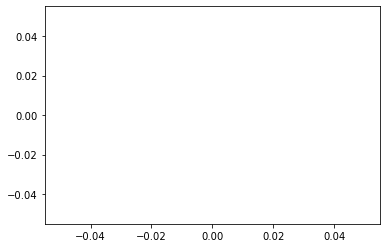

In [112]:
import seaborn as sns
p = sns.lineplot(data=resdf, x="threshold", y="accuracy", label='accuracy')
p = sns.lineplot(data=resdf, x="threshold", y="precision", label='precision')
p = sns.lineplot(data=resdf, x="threshold", y="recall", label='recall')
p = sns.lineplot(data=resdf, x="threshold", y="fscore", label='fscore')
p = sns.lineplot(data=resdf, x="threshold", y="false_positives", label='false_pos')
p.set(ylim=(0,1))
p.legend()

### Models

- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://www.analyticsvidhya.com/blog/2021/04/beginners-guide-to-logistic-regression-using-python/

In [113]:
# setup logistic regression
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

len(valid_ann_df)

700

- Select variables for regression

In [114]:
valid_ann_df.columns

Index(['muse_id', 'sentence_id', 'page_tokens', 'indicator_code',
       'ann_ex_tokens', 'valid_match', 'token_n', 'lemma_n',
       'ann_overlap_lemma', 'ann_overlap_token', 'example_len',
       'txt_overlap_lemma', 'txt_overlap_token', 'ann_overlap_criticwords',
       'lemmatoken_n', 'ann_overlap_tokenlemma', 'valid_match_b',
       'indicator_code_closed_indef', 'indicator_code_closed_perm',
       'indicator_code_finance_health', 'indicator_code_funding_did_not_get',
       'indicator_code_funding_fundraise', 'indicator_code_funding_gov_emer',
       'indicator_code_funding_other_emer', 'indicator_code_lang_difficulty',
       'indicator_code_online_engag', 'indicator_code_online_event',
       'indicator_code_online_exhib', 'indicator_code_open_cafe',
       'indicator_code_open_cur', 'indicator_code_open_onlineshop',
       'indicator_code_project_postpone', 'indicator_code_reopen_intent',
       'indicator_code_reopen_plan', 'indicator_code_staff_hiring',
       'indicator_co

In [75]:
#cols = ['indicator_code','lemmatoken_n','ann_overlap_tokenlemma','example_len']

In [115]:
valid_ann_df['indicator_code'].unique()

array(['funding_fundraise', 'closed_cur', 'online_exhib',
       'open_onlineshop', 'reopen_intent', 'funding_other_emer',
       'open_cur', 'reopen_plan', 'lang_difficulty', 'closed_indef',
       'finance_health', 'staff_working', 'online_event', 'online_engag',
       'funding_gov_emer', 'staff_hiring', 'open_cafe', 'closed_perm',
       'project_postpone', 'funding_did_not_get'], dtype=object)

In [116]:
valid_ann_df.groupby('indicator_code').mean()

,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,txt_overlap_lemma,txt_overlap_token,ann_overlap_criticwords,lemmatoken_n,ann_overlap_tokenlemma,...,indicator_code_online_exhib,indicator_code_open_cafe,indicator_code_open_cur,indicator_code_open_onlineshop,indicator_code_project_postpone,indicator_code_reopen_intent,indicator_code_reopen_plan,indicator_code_staff_hiring,indicator_code_staff_working,txt_overlap_tokenlemma
indicator_code,,,,,,,,,,,,,,,,,,,,,
closed_cur,2.103261,1.956522,0.610322,0.680754,3.304348,0.214460,0.248595,0.711957,2.228261,0.719794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260913
closed_indef,2.388889,2.277778,0.696296,0.721297,3.333333,0.230277,0.232699,0.675926,2.444444,0.739815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.243811
closed_perm,1.333333,2.000000,0.326923,0.217950,10.000000,0.249640,0.108227,0.000000,2.000000,0.326923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249640
finance_health,2.000000,2.000000,0.400000,0.400000,5.000000,0.234845,0.234845,0.250000,2.000000,0.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234845
funding_did_not_get,1.000000,1.250000,0.218750,0.156250,7.000000,0.080305,0.070690,0.208333,1.250000,0.218750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080305
funding_fundraise,1.838710,2.096774,0.564901,0.485421,4.666667,0.189919,0.166155,0.390681,2.096774,0.564901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.189919
funding_gov_emer,1.333333,1.333333,0.127273,0.127273,10.333333,0.122863,0.122863,0.000000,1.333333,0.127273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122863
funding_other_emer,1.333333,1.333333,0.095173,0.095173,14.000000,0.132212,0.132212,0.083333,1.333333,0.095173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132212
lang_difficulty,1.585366,1.804878,0.390041,0.320702,5.292683,0.124073,0.104484,0.109756,1.829268,0.394920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125357


In [117]:
valid_ann_df.groupby('valid_match_b').mean()

,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,txt_overlap_lemma,txt_overlap_token,ann_overlap_criticwords,lemmatoken_n,ann_overlap_tokenlemma,...,indicator_code_online_exhib,indicator_code_open_cafe,indicator_code_open_cur,indicator_code_open_onlineshop,indicator_code_project_postpone,indicator_code_reopen_intent,indicator_code_reopen_plan,indicator_code_staff_hiring,indicator_code_staff_working,txt_overlap_tokenlemma
valid_match_b,,,,,,,,,,,,,,,,,,,,,
False,1.561338,1.713755,0.411611,0.373247,5.163569,0.142280,0.132520,0.203841,1.743494,0.423108,...,0.011152,0.026022,0.011152,0.052045,0.011152,0.163569,0.055762,0.018587,0.037175,0.147591
True,3.023202,3.106729,0.725224,0.715867,4.301624,0.331967,0.329233,0.746713,3.215777,0.767838,...,0.016241,0.000000,0.020882,0.025522,0.000000,0.380510,0.023202,0.006961,0.039443,0.349503


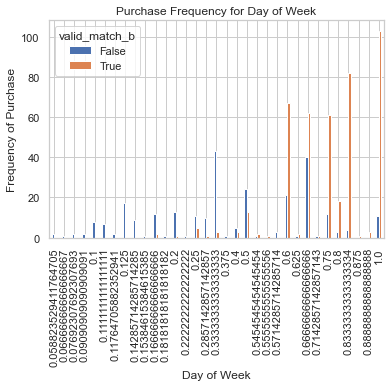

In [118]:
pd.crosstab(valid_ann_df.ann_overlap_tokenlemma, valid_ann_df.valid_match_b).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofweek_bar')

#### Var selection

In [142]:
#print(valid_ann_df.columns)
#model_vars = ['lemmatoken_n','txt_overlap_tokenlemma','ann_overlap_criticwords','example_len','valid_match_b']
# ,'ann_overlap_tokenlemma',

#model_vars.extend(indicator_dummy_vars.tolist()) # Add dummy vars

#print(model_vars)
#num_df = valid_ann_df[model_vars]
# 'indicator_code'
#num_df.columns
#num_df.corr('spearman')

#### Compare models with test/train

In [156]:
# train/test split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


if False:
    # normalise variables
    x_training_data = StandardScaler().fit_transform(x_training_data)

eval_dfs = ['matches_valid_ann_df_v1.pik','matches_valid_ann_df_v2.pik']

in_var_groups = [
    ['txt_overlap_tokenlemma'],
    ['ann_overlap_tokenlemma'],
    ['ann_overlap_criticwords'],
    ['txt_overlap_tokenlemma','ann_overlap_criticwords'],
    ['lemmatoken_n','txt_overlap_tokenlemma','ann_overlap_criticwords','example_len'],
    ['lemmatoken_n','ann_overlap_tokenlemma','txt_overlap_tokenlemma','example_len'],
    ['lemmatoken_n','txt_overlap_tokenlemma','ann_overlap_criticwords','example_len'],
]

var_groups = []
for x in in_var_groups: 
    x1 = x.copy()
    x1.extend(indicator_dummy_vars.tolist()) 
    x.append('valid_match_b')
    x1.append('valid_match_b')
    var_groups.append(x)
    var_groups.append(x1)

# iterate over models
models = [
    LogisticRegression(random_state=0),
    LogisticRegression(random_state=23),
    #svm.SVC(random_state=0),
    MLPClassifier(random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1),
    MLPClassifier(solver='sgd', random_state=1),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB(),
    #KNeighborsClassifier(3),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    #AdaBoostClassifier(),
    #QuadraticDiscriminantAnalysis()
]
for i in [2,5,10,20]:
    models.append(RandomForestClassifier(max_depth=i, random_state=10))

resdf = pd.DataFrame()

for valid_ann_df_fn in eval_dfs:
    # load validation dataset
    print(40*'-')
    print(valid_ann_df_fn)
    valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)
    
    for var_group in var_groups:
        # extract numeric matrix
        #print(var_group)
        if not pd.Series(var_group).isin(valid_ann_df.columns).all():
            # skip
            continue
        num_df = valid_ann_df[var_group]
        # loop through test sizes
        for test_size in [.2,.3,.4,.5]:
            for clf in models:
                print(valid_ann_df_fn, len(var_group), test_size, clf)
                y_data = num_df['valid_match_b']
                x_data = num_df.drop('valid_match_b', axis = 1)
                x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = test_size, random_state=2)
                
                #print(len(x_training_data), len(x_test_data))

                # Train the model and create predictions
                clf.fit(x_training_data, y_training_data)
                predictions = clf.predict(x_test_data)

                #print('vars N',len(x_data.columns))

                #print('Coefficients')
                #print(model.coef_, model.intercept_)

                # confusion matrix
                confmat = confusion_matrix(y_test_data, predictions, normalize='all')
                #print(confmat)
                tn, fp, fn, tp = confmat.ravel()
                #print('tn, fp, fn, tp')
                #print(round(tn,2), round(fp,2),round(fn,2),round(tp,2))

                # scores
                precision, recall, fscore, support = precision_recall_fscore_support(y_test_data, predictions, average='binary')
                acc = accuracy_score(y_test_data, predictions)
                #print(classification_report(y_test_data, predictions))
                #print('acc', round(acc,2), '; precision', round(precision,2), '; recall', round(recall,2), '; fscore', round(fscore,2))
                del x_training_data, x_test_data, y_training_data, y_test_data

                # cross-validation
                crossval_predicted = cross_val_predict(clf, x_data, y_data, cv=6)
                #print("X vars:", len(x_data.columns))
                crossval_acc = round(accuracy_score(y_data, crossval_predicted),2)
                del crossval_predicted

                # pack results
                subdf = pd.DataFrame.from_dict({
                    'eval_file': valid_ann_df_fn,
                    'var_group':' '.join(var_group),
                    'model':str(clf), 'test_size':test_size, 'x_shape':str(x_data.shape),
                    'accuracy': round(acc,2),
                    'precision':[round(precision,3)], 'recall':[round(recall,3)], 
                    'fscore':[round(fscore,3)], 
                    'crossval_acc': crossval_acc,
                    'false_pos': round(fp,2),'false_neg': round(fn,2)})
                resdf = pd.concat([resdf, subdf])
                # clean up
                del precision, recall, fscore, support
                del acc
                del clf
                del tn, fp, fn, tp
                del predictions
                del x_data,y_data
        del num_df
    del valid_ann_df

resdf = resdf.sort_values(by='accuracy', ascending=False)
resdf.to_excel(out_folder+'tmp/match_validation_model_comparison.xlsx', index=False)
resdf

----------------------------------------
matches_valid_ann_df_v1.pik
matches_valid_ann_df_v1.pik 2 0.2 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 2 0.2 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 2 0.2 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


matches_valid_ann_df_v1.pik 2 0.2 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 2 0.2 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 2 0.2 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 2 0.2 GaussianNB()
matches_valid_ann_df_v1.pik 2 0.2 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 2 0.2 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 2 0.2 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 2 0.2 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 2 0.2 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 2 0.3 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 2 0.3 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 2 0.3 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


matches_valid_ann_df_v1.pik 2 0.3 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 2 0.3 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 2 0.3 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 2 0.3 GaussianNB()
matches_valid_ann_df_v1.pik 2 0.3 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 2 0.3 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 2 0.3 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 2 0.3 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 2 0.3 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 2 0.4 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 2 0.4 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 2 0.4 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


matches_valid_ann_df_v1.pik 2 0.4 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 2 0.4 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 2 0.4 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 2 0.4 GaussianNB()
matches_valid_ann_df_v1.pik 2 0.4 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 2 0.4 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 2 0.4 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 2 0.4 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 2 0.4 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 2 0.5 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 2 0.5 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 2 0.5 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


matches_valid_ann_df_v1.pik 2 0.5 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 2 0.5 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 2 0.5 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 2 0.5 GaussianNB()
matches_valid_ann_df_v1.pik 2 0.5 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 2 0.5 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 2 0.5 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 2 0.5 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 2 0.5 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 21 0.2 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 21 0.2 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 21 0.2 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.2 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multila

matches_valid_ann_df_v1.pik 21 0.2 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.2 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 21 0.2 GaussianNB()
matches_valid_ann_df_v1.pik 21 0.2 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 21 0.2 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 21 0.2 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 21 0.2 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 21 0.2 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 21 0.3 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 21 0.3 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 21 0.3 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.3 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multila

matches_valid_ann_df_v1.pik 21 0.3 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.3 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 21 0.3 GaussianNB()
matches_valid_ann_df_v1.pik 21 0.3 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 21 0.3 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 21 0.3 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 21 0.3 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 21 0.3 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 21 0.4 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 21 0.4 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 21 0.4 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.4 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multila

matches_valid_ann_df_v1.pik 21 0.4 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.4 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 21 0.4 GaussianNB()
matches_valid_ann_df_v1.pik 21 0.4 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 21 0.4 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 21 0.4 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 21 0.4 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 21 0.4 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 21 0.5 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 21 0.5 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 21 0.5 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.5 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multila

matches_valid_ann_df_v1.pik 21 0.5 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.5 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 21 0.5 GaussianNB()
matches_valid_ann_df_v1.pik 21 0.5 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 21 0.5 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 21 0.5 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 21 0.5 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 21 0.5 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 2 0.2 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 2 0.2 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 2 0.2 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


matches_valid_ann_df_v1.pik 2 0.2 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 2 0.2 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 2 0.2 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 2 0.2 GaussianNB()
matches_valid_ann_df_v1.pik 2 0.2 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 2 0.2 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 2 0.2 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 2 0.2 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 2 0.2 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 2 0.3 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 2 0.3 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 2 0.3 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


matches_valid_ann_df_v1.pik 2 0.3 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 2 0.3 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 2 0.3 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 2 0.3 GaussianNB()
matches_valid_ann_df_v1.pik 2 0.3 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 2 0.3 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 2 0.3 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 2 0.3 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 2 0.3 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 2 0.4 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 2 0.4 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 2 0.4 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 2 0.4 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 2 0.4 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 2 0.4 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 2 0.4 GaussianNB()
matches_valid_ann_df_v1.pik 2 0.4 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 2 0.4 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 2 0.4 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 2 0.4 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 2 0.4 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 2 0.5 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 2 0.5 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 2 0.5 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 2 0.5 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 2 0.5 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 2 0.5 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 2 0.5 GaussianNB()
matches_valid_ann_df_v1.pik 2 0.5 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 2 0.5 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 2 0.5 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 2 0.5 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 2 0.5 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 21 0.2 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 21 0.2 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 21 0.2 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.2 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multila

matches_valid_ann_df_v1.pik 21 0.2 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.2 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 21 0.2 GaussianNB()
matches_valid_ann_df_v1.pik 21 0.2 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 21 0.2 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 21 0.2 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 21 0.2 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 21 0.2 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 21 0.3 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 21 0.3 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 21 0.3 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.3 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multila

matches_valid_ann_df_v1.pik 21 0.3 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.3 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 21 0.3 GaussianNB()
matches_valid_ann_df_v1.pik 21 0.3 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 21 0.3 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 21 0.3 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 21 0.3 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 21 0.3 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 21 0.4 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 21 0.4 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 21 0.4 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.4 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multila

matches_valid_ann_df_v1.pik 21 0.4 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.4 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 21 0.4 GaussianNB()
matches_valid_ann_df_v1.pik 21 0.4 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 21 0.4 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 21 0.4 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 21 0.4 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 21 0.4 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 21 0.5 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 21 0.5 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 21 0.5 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.5 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multila

matches_valid_ann_df_v1.pik 21 0.5 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 21 0.5 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 21 0.5 GaussianNB()
matches_valid_ann_df_v1.pik 21 0.5 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 21 0.5 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 21 0.5 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 21 0.5 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 21 0.5 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 5 0.2 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 5 0.2 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 5 0.2 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 5 0.2 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 5 0.2 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 5 0.2 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 5 0.2 GaussianNB()
matches_valid_ann_df_v1.pik 5 0.2 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 5 0.2 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 5 0.2 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 5 0.2 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 5 0.2 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 5 0.3 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 5 0.3 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 5 0.3 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 5 0.3 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 5 0.3 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 5 0.3 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 5 0.3 GaussianNB()
matches_valid_ann_df_v1.pik 5 0.3 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 5 0.3 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 5 0.3 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 5 0.3 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 5 0.3 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 5 0.4 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 5 0.4 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 5 0.4 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 5 0.4 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 5 0.4 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 5 0.4 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 5 0.4 GaussianNB()
matches_valid_ann_df_v1.pik 5 0.4 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 5 0.4 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 5 0.4 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 5 0.4 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 5 0.4 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 5 0.5 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 5 0.5 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 5 0.5 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 5 0.5 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 5 0.5 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 5 0.5 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 5 0.5 GaussianNB()
matches_valid_ann_df_v1.pik 5 0.5 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 5 0.5 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 5 0.5 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 5 0.5 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 5 0.5 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 24 0.2 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 24 0.2 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 24 0.2 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 24 0.2 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 24 0.2 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 24 0.2 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 24 0.2 GaussianNB()
matches_valid_ann_df_v1.pik 24 0.2 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 24 0.2 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 24 0.2 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 24 0.2 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 24 0.2 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 24 0.3 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 24 0.3 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 24 0.3 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 24 0.3 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 24 0.3 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 24 0.3 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 24 0.3 GaussianNB()
matches_valid_ann_df_v1.pik 24 0.3 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 24 0.3 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 24 0.3 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 24 0.3 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 24 0.3 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 24 0.4 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 24 0.4 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 24 0.4 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 24 0.4 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 24 0.4 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 24 0.4 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 24 0.4 GaussianNB()
matches_valid_ann_df_v1.pik 24 0.4 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 24 0.4 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 24 0.4 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 24 0.4 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 24 0.4 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v1.pik 24 0.5 LogisticRegression(random_state=0)
matches_valid_ann_df_v1.pik 24 0.5 LogisticRegression(random_state=23)
matches_valid_ann_df_v1.pik 24 0.5 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 24 0.5 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v1.pik 24 0.5 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v1.pik 24 0.5 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v1.pik 24 0.5 GaussianNB()
matches_valid_ann_df_v1.pik 24 0.5 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v1.pik 24 0.5 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v1.pik 24 0.5 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v1.pik 24 0.5 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v1.pik 24 0.5 RandomForestClassifier(max_depth=20, random_state=10)
----------------------------------------
matches_valid_ann_df_v2.pik
matches_valid_ann_df_v2.pik 2 0.2 LogisticRegression(random_state=0)
matches_valid_ann_df_v2.pik 2 0.2 LogisticRegression(random_state=23)
matches_valid_ann_df_v2.pik 2 0.2 MLPClassifier(random_state=1)
matches_valid_ann_df_v2.pik 2 0.2 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v2.pik 2 0.2 MLPClassifier(

/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v2.pik 2 0.2 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v2.pik 2 0.2 GaussianNB()
matches_valid_ann_df_v2.pik 2 0.2 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v2.pik 2 0.2 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v2.pik 2 0.2 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v2.pik 2 0.2 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v2.pik 2 0.2 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v2.pik 2 0.3 LogisticRegression(random_state=0)
matches_valid_ann_df_v2.pik 2 0.3 LogisticRegression(random_state=23)
matches_valid_ann_df_v2.pik 2 0.3 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


matches_valid_ann_df_v2.pik 2 0.3 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v2.pik 2 0.3 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v2.pik 2 0.3 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v2.pik 2 0.3 GaussianNB()
matches_valid_ann_df_v2.pik 2 0.3 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v2.pik 2 0.3 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v2.pik 2 0.3 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v2.pik 2 0.3 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v2.pik 2 0.3 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v2.pik 2 0.4 LogisticRegression(random_state=0)
matches_valid_ann_df_v2.pik 2 0.4 LogisticRegression(random_state=23)
matches_valid_ann_df_v2.pik 2 0.4 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


matches_valid_ann_df_v2.pik 2 0.4 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v2.pik 2 0.4 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v2.pik 2 0.4 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v2.pik 2 0.4 GaussianNB()
matches_valid_ann_df_v2.pik 2 0.4 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v2.pik 2 0.4 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v2.pik 2 0.4 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v2.pik 2 0.4 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v2.pik 2 0.4 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v2.pik 2 0.5 LogisticRegression(random_state=0)
matches_valid_ann_df_v2.pik 2 0.5 LogisticRegression(random_state=23)
matches_valid_ann_df_v2.pik 2 0.5 MLPClassifier(random_state=1)


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


matches_valid_ann_df_v2.pik 2 0.5 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v2.pik 2 0.5 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v2.pik 2 0.5 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v2.pik 2 0.5 GaussianNB()
matches_valid_ann_df_v2.pik 2 0.5 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v2.pik 2 0.5 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v2.pik 2 0.5 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v2.pik 2 0.5 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v2.pik 2 0.5 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v2.pik 2 0.2 LogisticRegression(random_state=0)
matches_valid_ann_df_v2.pik 2 0.2 LogisticRegression(random_state=23)
matches_valid_ann_df_v2.pik 2 0.2 MLPClassifier(random_state=1)
matches_valid_ann_df_v2.pik 2 0.2 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v2.pik 2 0.2 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v2.pik 2 0.2 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v2.pik 2 0.2 GaussianNB()
matches_valid_ann_df_v2.pik 2 0.2 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v2.pik 2 0.2 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v2.pik 2 0.2 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v2.pik 2 0.2 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v2.pik 2 0.2 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v2.pik 2 0.3 LogisticRegression(random_state=0)
matches_valid_ann_df_v2.pik 2 0.3 LogisticRegression(random_state=23)
matches_valid_ann_df_v2.pik 2 0.3 MLPClassifier(random_state=1)
matches_valid_ann_df_v2.pik 2 0.3 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v2.pik 2 0.3 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v2.pik 2 0.3 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v2.pik 2 0.3 GaussianNB()
matches_valid_ann_df_v2.pik 2 0.3 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v2.pik 2 0.3 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v2.pik 2 0.3 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v2.pik 2 0.3 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v2.pik 2 0.3 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v2.pik 2 0.4 LogisticRegression(random_state=0)
matches_valid_ann_df_v2.pik 2 0.4 LogisticRegression(random_state=23)
matches_valid_ann_df_v2.pik 2 0.4 MLPClassifier(random_state=1)
matches_valid_ann_df_v2.pik 2 0.4 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v2.pik 2 0.4 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v2.pik 2 0.4 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v2.pik 2 0.4 GaussianNB()
matches_valid_ann_df_v2.pik 2 0.4 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v2.pik 2 0.4 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v2.pik 2 0.4 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v2.pik 2 0.4 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v2.pik 2 0.4 RandomForestClassifier(max_depth=20, random_state=10)
matches_valid_ann_df_v2.pik 2 0.5 LogisticRegression(random_state=0)
matches_valid_ann_df_v2.pik 2 0.5 LogisticRegression(random_state=23)
matches_valid_ann_df_v2.pik 2 0.5 MLPClassifier(random_state=1)
matches_valid_ann_df_v2.pik 2 0.5 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
matches_valid_ann_df_v2.pik 2 0.5 MLPClassifier(random_state=1, solver='sgd')


/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andreaballatore/opt/anaconda3/envs/mip_v1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

matches_valid_ann_df_v2.pik 2 0.5 MLPClassifier(alpha=1, max_iter=1000)
matches_valid_ann_df_v2.pik 2 0.5 GaussianNB()
matches_valid_ann_df_v2.pik 2 0.5 DecisionTreeClassifier(max_depth=5)
matches_valid_ann_df_v2.pik 2 0.5 RandomForestClassifier(max_depth=2, random_state=10)
matches_valid_ann_df_v2.pik 2 0.5 RandomForestClassifier(max_depth=5, random_state=10)
matches_valid_ann_df_v2.pik 2 0.5 RandomForestClassifier(max_depth=10, random_state=10)
matches_valid_ann_df_v2.pik 2 0.5 RandomForestClassifier(max_depth=20, random_state=10)


,eval_file,var_group,model,test_size,x_shape,accuracy,precision,recall,fscore,crossval_acc,false_pos,false_neg
0,matches_valid_ann_df_v1.pik,ann_overlap_tokenlemma indicator_code_closed_i...,LogisticRegression(random_state=23),0.3,"(700, 20)",0.85,0.836,0.929,0.880,0.77,0.11,0.04
0,matches_valid_ann_df_v1.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,"MLPClassifier(alpha=1, max_iter=1000)",0.5,"(700, 23)",0.85,0.838,0.929,0.881,0.77,0.11,0.04
0,matches_valid_ann_df_v1.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,GaussianNB(),0.3,"(700, 4)",0.85,0.852,0.913,0.881,0.75,0.10,0.05
0,matches_valid_ann_df_v1.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,LogisticRegression(random_state=23),0.5,"(700, 23)",0.85,0.835,0.929,0.879,0.78,0.11,0.04
0,matches_valid_ann_df_v1.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,LogisticRegression(random_state=0),0.5,"(700, 23)",0.85,0.835,0.929,0.879,0.78,0.11,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...
0,matches_valid_ann_df_v1.pik,ann_overlap_tokenlemma valid_match_b,"MLPClassifier(random_state=1, solver='sgd')",0.2,"(700, 1)",0.59,0.586,1.000,0.739,0.62,0.41,0.00
0,matches_valid_ann_df_v1.pik,ann_overlap_tokenlemma valid_match_b,"MLPClassifier(alpha=1e-05, hidden_layer_sizes=...",0.2,"(700, 1)",0.59,0.586,1.000,0.739,0.62,0.41,0.00
0,matches_valid_ann_df_v1.pik,txt_overlap_tokenlemma indicator_code_closed_i...,"MLPClassifier(random_state=1, solver='sgd')",0.4,"(700, 20)",0.59,0.586,1.000,0.739,0.62,0.41,0.00
0,matches_valid_ann_df_v1.pik,txt_overlap_tokenlemma indicator_code_closed_i...,"MLPClassifier(random_state=1, solver='sgd')",0.2,"(700, 20)",0.59,0.586,1.000,0.739,0.62,0.41,0.00


In [ ]:
TODO deep learning: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

End of notebook